In [22]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import wave
import struct

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Generator(nn.Module):
    def __init__(self, d):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 256*d)
        self.tconv1 = nn.ConvTranspose1d(16*d, 8*d, 25, stride = 4)
        self.tconv2 = nn.ConvTranspose1d(8*d, 4*d, 25, stride = 4)
        self.tconv3 = nn.ConvTranspose1d(4*d, 2*d, 25, stride = 4)
        self.tconv4 = nn.ConvTranspose1d(2*d, d, 25, stride = 4)
        self.tconv5 = nn.ConvTranspose1d(d, 1, 25, stride = 4)
    
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out.reshape(-1, 16*d, 16))
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        out = F.relu(self.tconv4(out))
        out = F.relu(self.tconv5(out))
        out = F.tanh(out)
        return out

In [12]:
class Discriminator(nn.Module):
    def __init__(self, d):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, d, 25, stride = 4)
        self.conv2 = nn.Conv1d(d, 2*d, 25, stride = 4)
        self.conv3 = nn.Conv1d(2*d, 4*d, 25, stride = 4)
        self.conv4 = nn.Conv1d(4*d, 8*d, 25, stride = 4)
        self.conv5 = nn.Conv1d(8*d, 16*d, 25, stride = 4)
        self.linear = nn.Linear(256*d, 1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = out.reshape(-1, 256*d)
        out = self.linear(out)
        return out 

In [15]:
data_one = './data/speech_commands_v0.01/one/'
files = os.listdir(data_one)

In [17]:
with wave.open(os.path.join(data_one, files[0])) as f:
    params = f.getparams()

In [18]:
params

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')

In [69]:
data = []
with wave.open(files[0]) as f:
    data = f.readframes(params.nframes)

In [70]:
len(data)

32000

In [39]:
float_data = []
for i in range(params.nframes):
    x = struct.unpack('h', data[i:i+2])
    float_data.append(x[0])
float_data = np.array(float_data, dtype = np.float32)

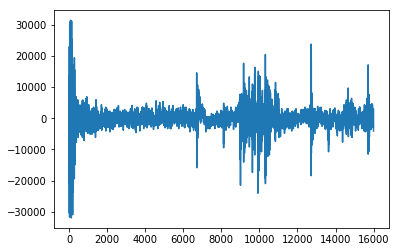

In [40]:
plt.plot(float_data)

In [41]:
float_data = np.pad(float_data, 192, 'constant', constant_values=((0, 0)))

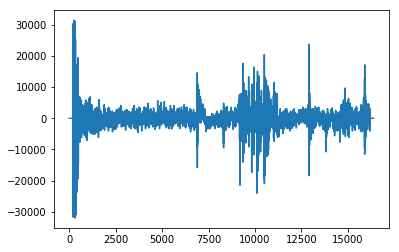

In [42]:
plt.plot(float_data)

In [43]:
float_data.shape

(16384,)

In [44]:
len(files)

2370

In [88]:
base_dir = './data/speech_commands_v0.01/'
# names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
names = ['one']
files = []
for folder in os.listdir(base_dir):
    if folder in names:
        folder_files = os.listdir(os.path.join(base_dir, folder))
        base = os.path.join(base_dir, folder)
        files.extend([os.path.join(base, f) for f in folder_files])

In [89]:
len(files)

2370

In [90]:
files[0]

'./data/speech_commands_v0.01/one\\00176480_nohash_0.wav'

In [95]:
train_data = []
for i, file in enumerate(files):
    with wave.open(file) as f:
        data = f.readframes(params.nframes)
    if len(data) != 32000:
        continue
    data_float = np.zeros((16384, ), dtype = np.float32)
    for j in range(0, len(data), 2):
        x_int = struct.unpack('h', data[j:j+2])
        data_float[192 + j//2] = float(x_int[0])
    train_data.append(data_float)
train_data = np.array(train_data, dtype = np.float32)

In [96]:
train_data.shape

(2103, 16384)

In [103]:
def get_batch(train_data, batch_size):
    idx = np.random.randint(0, len(train_data), size=batch_size)
    batch = train_data[idx]
    return batch

In [104]:
x = get_batch(train_data, 32)
x.shape

(32, 16384)

In [ ]:
batch_size = 32
n = 5
n_disc = 5
r = 10
G = Generator()
D = Discriminator()
G_optim = optim.Adam(G.parameters(), 0.0001, betas = (0, 0.9))
D_optim = optim.Adam(D.parameters(), 0.0001, betas = (0, 0.9))
criterion_
for i in range(n):
    for j in range(n_disc):
        real = get_batch(train_data, batch_size)
        real = torch.tensor(real).to(device)
        z = 2*torch.rand(batch_size, 16384) - 1
        z = z.to(device)
        fake = G(z)
        eps = torch.rand(batch_size)
        real_fake = eps*real + (1 - eps)*fake
        D_real = D(real)
        D_fake = D(fake)
        penalty = r*(torch.norm( , p = 2, dim = 1))
        
        
        
    